In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from yellowbrick.classifier import ClassificationReport


In [3]:
# Ignore future and user warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
# Read the dataset
df = pd.read_csv('../input/crop-recommendation-dataset/Crop_recommendation.csv')

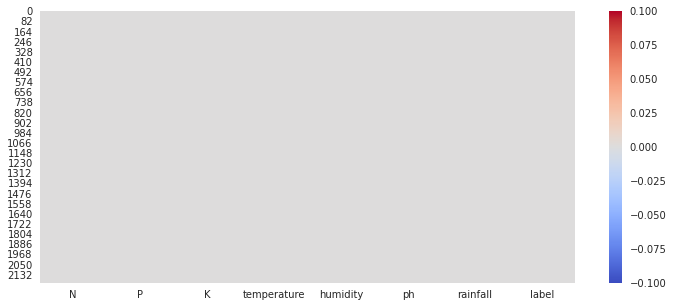

In [5]:
# Visualization with seaborn and matplotlib
plt.figure(figsize=(12, 5))
sns.heatmap(df.isnull(), cmap="coolwarm")
plt.show()

<AxesSubplot:xlabel='P', ylabel='label'>

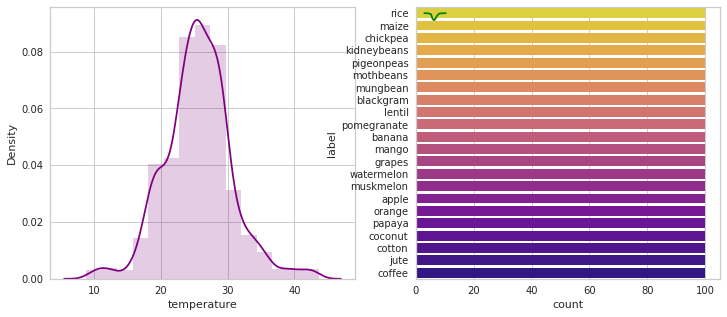

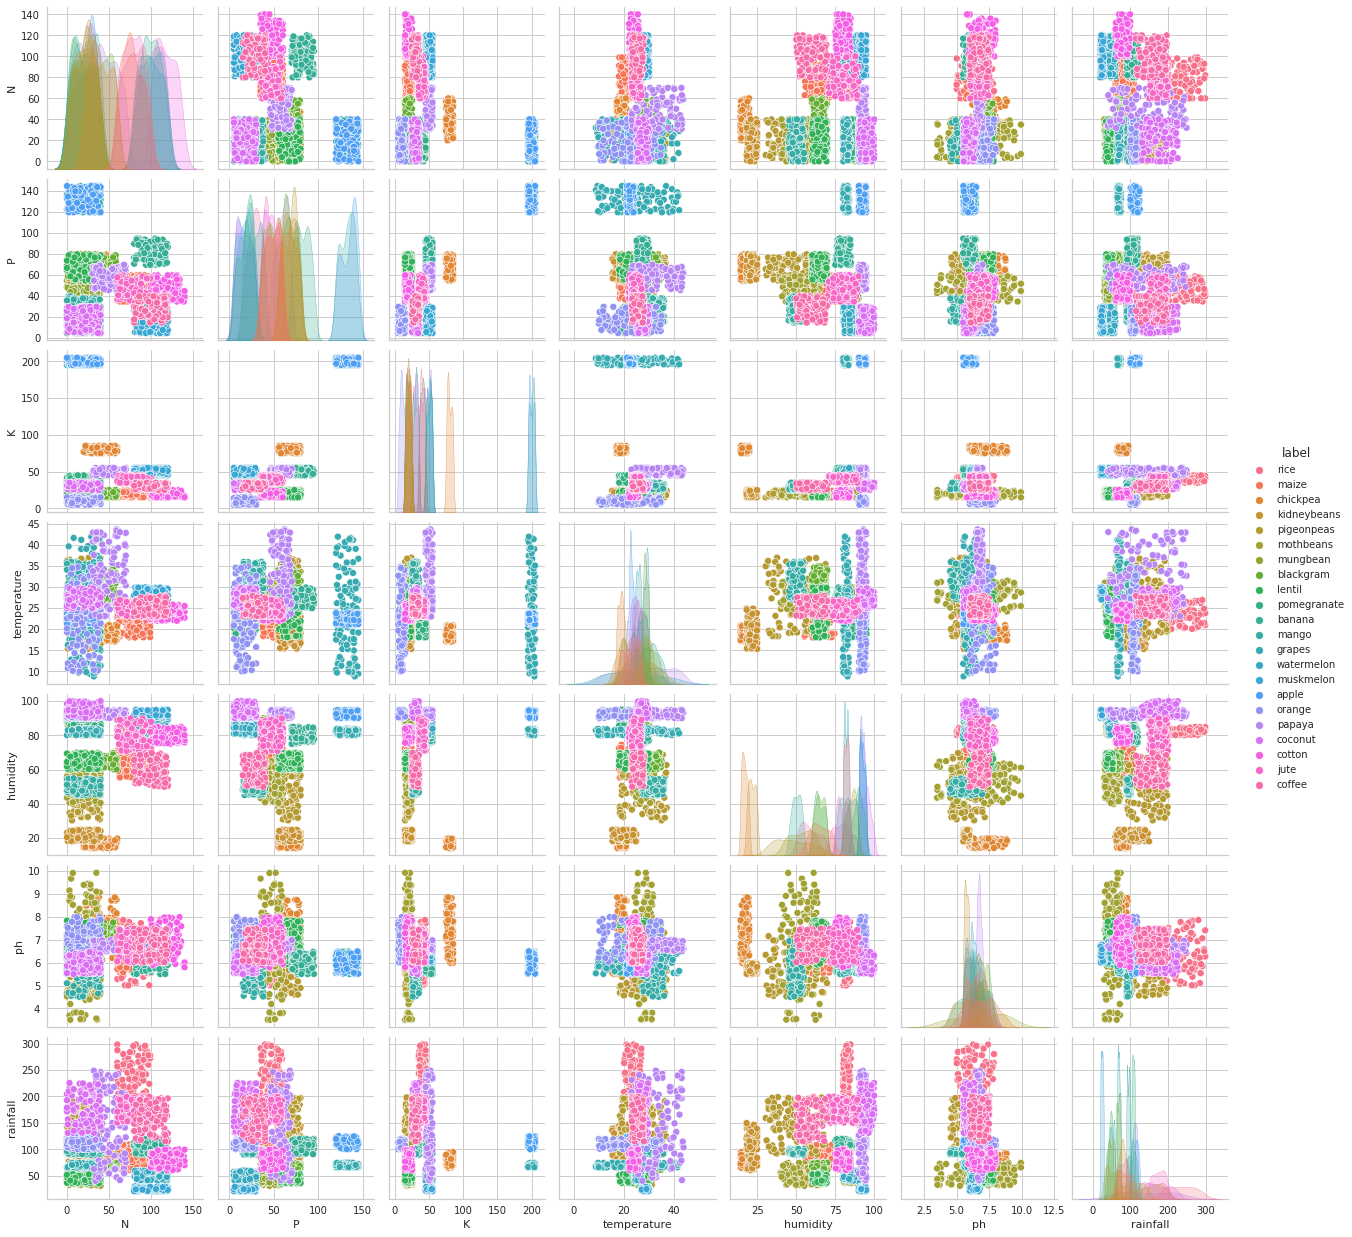

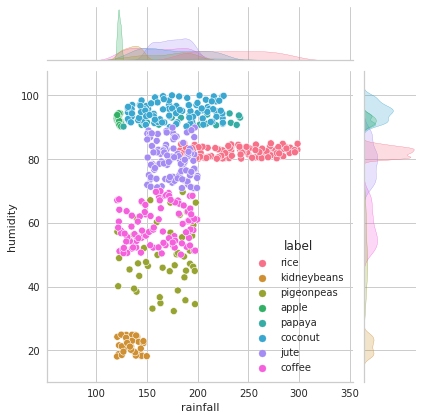

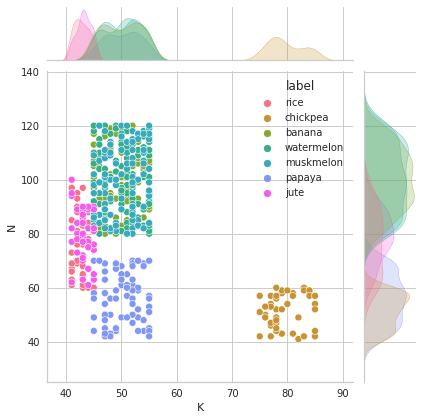

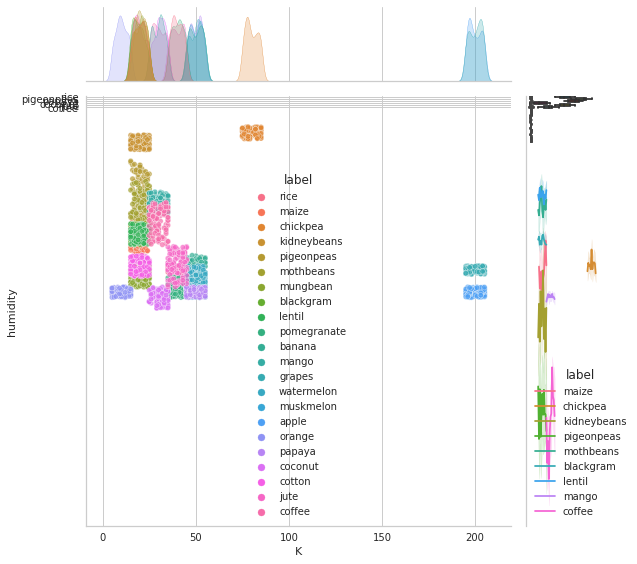

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(df['temperature'], color="purple", bins=15, hist_kws={'alpha': 0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'], color="green", bins=15, hist_kws={'alpha': 0.2})
sns.countplot(y='label', data=df, palette="plasma_r")
sns.pairplot(df, hue='label')
sns.jointplot(x="rainfall", y="humidity", data=df[(df['temperature'] < 30) & (df['rainfall'] > 120)], hue="label")
sns.jointplot(x="K", y="N", data=df[(df['N'] > 40) & (df['K'] > 40)], hue="label")
sns.jointplot(x="K", y="humidity", data=df, hue='label', size=8, s=30, alpha=0.7)
sns.boxplot(y='label', x='ph', data=df)
sns.boxplot(y='label', x='P', data=df[df['rainfall'] > 150])
sns.lineplot(data=df[(df['humidity'] < 65)], x="K", y="rainfall", hue="label")

In [7]:
c = df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target'] = c.cat.codes


In [8]:
# Splitting the data
y = df.target
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [9]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_score = knn.score(X_test_scaled, y_test)

In [11]:
# Confusion Matrix
mat = confusion_matrix(y_test, knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))

In [12]:
# Hyperparameter tuning for K-Nearest Neighbors
k_range = range(1, 11)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

In [13]:
# Support Vector Classifier with Linear Kernel
svc_linear = SVC(kernel='linear').fit(X_train_scaled, y_train)
svc_linear_acc = svc_linear.score(X_test_scaled, y_test)

In [14]:
# Support Vector Classifier with Radial Basis Function (RBF) Kernel
svc_rbf = SVC(kernel='rbf').fit(X_train_scaled, y_train)
svc_rbf_acc = svc_rbf.score(X_test_scaled, y_test)

In [15]:
# Support Vector Classifier with Polynomial Kernel
svc_poly = SVC(kernel='poly').fit(X_train_scaled, y_train)
svc_poly_acc = svc_poly.score(X_test_scaled, y_test)

In [16]:
# Hyperparameter tuning using GridSearchCV for SVM
parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist()}
model = GridSearchCV(estimator=SVC(kernel="linear"), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train, y_train)
best_score = model.best_score_
best_params = model.best_params_

In [17]:
# Decision Tree Classifier
clf_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf_tree_score = clf_tree.score(X_test, y_test)


In [18]:
# Random Forest Classifier
clf_rf = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42).fit(X_train, y_train)
clf_rf_train_acc = clf_rf.score(X_train, y_train)
clf_rf_test_acc = clf_rf.score(X_test, y_test)

In [19]:
# Gradient Boosting Classifier
grad_boost = GradientBoostingClassifier().fit(X_train, y_train)
grad_boost_acc = grad_boost.score(X_test, y_test)

0.9727272727272728

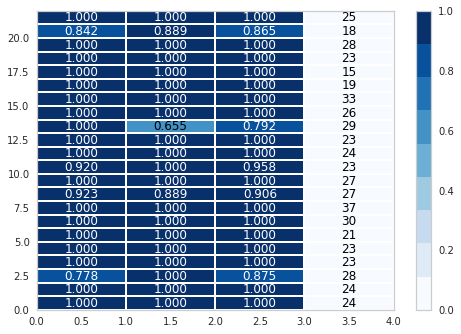

In [20]:
# Visualization with Yellowbrick Classification Report
classes = list(targets.values())
visualizer = ClassificationReport(clf_rf, classes=classes, support=True, cmap="Blues")
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

In [21]:
# Printing results
print("K-Nearest Neighbors Accuracy:", knn_score)
print("Linear Kernel SVM Accuracy:", svc_linear_acc)
print("RBF Kernel SVM Accuracy:", svc_rbf_acc)
print("Polynomial Kernel SVM Accuracy:", svc_poly_acc)
print("Best Cross-Validation Score for SVM:", best_score)
print("Best Parameters for SVM:", best_params)
print("Decision Tree Classifier Accuracy:", clf_tree_score)
print("Random Forest Classifier Accuracy (Train):", clf_rf_train_acc)
print("Random Forest Classifier Accuracy (Test):", clf_rf_test_acc)
print("Gradient Boosting Classifier Accuracy:", grad_boost_acc)

K-Nearest Neighbors Accuracy: 0.9781818181818182
Linear Kernel SVM Accuracy: 0.9745454545454545
RBF Kernel SVM Accuracy: 0.9872727272727273
Polynomial Kernel SVM Accuracy: 0.9890909090909091
Best Cross-Validation Score for SVM: 0.9866710547967747
Best Parameters for SVM: {'C': 1.0, 'gamma': 0.001}
Decision Tree Classifier Accuracy: 0.9872727272727273
Random Forest Classifier Accuracy (Train): 0.9715151515151516
Random Forest Classifier Accuracy (Test): 0.9727272727272728
Gradient Boosting Classifier Accuracy: 0.9927272727272727
